<a href="https://colab.research.google.com/github/s1c5000/Competition/blob/main/COMPAS/child_protection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMPAS 어린이 교통사고 위험지역 도출

COMPAS 에서 어린이 교통사고 위험지역을 도출하는 공모전을 개최했다.  
중요한 데이터는 외부 유출을 금해서 해당파일에선 사용을 못한다.

### 추진배경
오산시는 교육을 통해 도시혁신을 이루고자 지난 10년간 교육에 집중한 결과 오산백년시민대학 등 우수한 교육시스템을 갖추고 있으며, 국내외 다양한 네트워크를 기반으로 우수사례를 전파하기 위해 활발히 활동하는 세계 최고 학습도시 중 하나로 꼽히고 있으며 2011년 혁신교육지구 선정, 2015년 평생학습도시선정(교육부), 2017년 아동친화도시 인증(유니세프), 2019년 미래교육 등 “교육도시 오산”이라는 브랜드를 확립하였습니다.

그동안 구축한 교육 인프라를 기반으로 AI특별교육도시로 거듭나기 위해 오산메이커 교육센터 및 AI 특성화고 설립, AI기업 창업지원을 위한 TEG캠퍼스 조성하고 있으며, 운암뜰 복합단지를 AI 중심 복합단지로 설정하고 스마트시티를 구축하는 등 도시전역에서 AI기반 스마트 도시행정 혁신을 위해 노력하고 있습니다.

특히, 오산시는 ‘AI특별교육도시’ 및 ‘유니세프 아동친화도시’로써 스마트시티 통합운영 센터의 지능형 CCTV 솔루션을 활용해 교통사고 및 범죄를 사전에 예방하고 2020년에 경기연구원과 어린이 보호구역 보행안전 확보방안을 연구하는 듯 아동이 안전하고 행복하게 교육을 받을 수 있는 스마트 교육도시 구축을 위해 많은 노력을 하고 있습니다.

최근 어린이 교통사고의 중요성이 높아지고 있으나 학교, 유치원, 어린이집 주변과 유아, 어린이들이 활동하는 생활도로 및 통학로 등에, 불법주정차, 교통안전 시설물 미비 등 여러 가지 요인으로 인해 어린이 교통사고 발생 건수는 증가하고 있으며, 민식이법 제정 등으로 어린이 보호구역에 교통안전 시설물 설치가 의무화 되었으나 구체적인 지침이 없는 점을 감안해 데이터를 기반으로 어린이 교통사고를 감소시키고자 본 과제를 제안하였습니다.

### 분석목적
오산시는 어린이 교통사고 예방을 위해 다양한 데이터를 융합하고 활용하여 교통사고 예방을 위한
주정차 단속 강화, 교통 안전시설물 및 AI기반 스마트시티 솔루션 설치 등 어린이 보호를 위한 다양한 정책을 수립하여 추진 할 계획입니다.
### 해결 과제
* 어린이 보호구역 외 어린이 교통사고 위험지역 20개소 제시  
* 기존 어린이 보호구역 중 교통안전시설물* 우선 설치 지역 20개소 제시
> 교통안전시설물 : 과속단속카메라, 교통안전표지판, 미끄럼방지시설(적색포장), 과속방지턱, 가드휀스 등  
* 분석 조건
> 위험지역 범위설정은 중심점으로부터 반경 50m를 기준으로 함.(분석결과에 따라 제시 가능)
>
> 사용자가 자유롭게 필요 데이터를 발굴하여 사용 가능하나 최종 결과파일 제출 시 >데이터 출처와 사용한 데이터도 함께 제출
> 외부 데이터는 법적인 제약이 없는 경우에만 허용되며 크롤링을 통해 데이터를 생산 한 경우 크롤링 코드도 함께 제출

## 환경
COMPAS에서 제공하는 jupyter notebook  
CPU : 1 vCore  
Memory : 16GB

## 데이터 
34 개의 다양한 geodata가 주어진다.  

비공개 데이터는 외부 유출 금지, 제공받은 jupyter notebook 안에서만 API로 가져올 수 있다.

## 필요한 라이브러리와 함수 정의

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['font.family'] = 'Malgun Gothic'
sns.set(font='Malgun Gothic')

import warnings
warnings.filterwarnings('ignore')

import geopandas as gpd
import folium
import pydeck as pdk
import shapely
from shapely.geometry import Polygon, Point

In [ ]:
# 필요한 함수
# pydeck으로 시각화를 위해 정의하였다

# multipolycon을 coordinate형태로 반환
def multipolygon_to_coordinates(x): 
    lon, lat = x[0].exterior.xy
    return [[x, y] for x, y in zip(lon, lat)]

# multilinestring, linestring을 coordinate형태로 반환
def line_string_to_coordinates(line_string): 
    if isinstance(line_string, shapely.geometry.linestring.LineString): 
        lon, lat = line_string.xy 
        return [[x, y] for x, y in zip(lon, lat)] 
    elif isinstance(line_string, shapely.geometry.multilinestring.MultiLineString): 
        ret = [] 
        for i in range(len(line_string)): 
            lon, lat = line_string[i].xy 
            for x, y in zip(lon, lat): 
                ret.append([x, y])
        return ret 

# EDA

## 1. 어린이교통사고 분석

* 목적 : 어린이교통사고에 대한 통찰을 얻기위해서
* 데이터종류 : 2.오산시_어린이교통사고_격자.geojson ( 비공개)
* 컬럼 목록 
> gid  :  격자별 고유 분류코드.  
> accident_cnt  :  격자내 발생한 교통사고 횟수.
* 분석설명
> 어린이 교통사고 격자 데이터는 오산시를 100 X 100크기의 격자로 나누어 해당 그리드 안의 어린이 교통사고 수를 보여준다.       
> 요구하는 위험지역 범위설정이 중심반경을 기준으로 50m 이내이기에 해당 데이터의 격자크기는 변경하지 않고 분석하겠다.       
> 우선 데이터를 가져와 시각화 해보겠다

### 비고
해당 데이터는 비공개 데이터이다.  
때문에 해당데이터를 표현할 수 있는 직접적인 데이터들은 공개할 수 없고 출력물들은 모두 지웠다.  

이 데이터의 격자별 분류 코드를 기준으로 다른 데이터들을 병합하여 쓸만한 feature들을 만드는데 대부분의 시간을 사용했다.  
가장 중요하고 재미있는데 데이터였다.

In [ ]:
# 오산시_어린이교통사고_격자.geojson은 2010년 ~ 2019년 오산시 어린이 교통사고에 관한 100X100 격자 데이터입니다.
# gid는 격자별 분류코드 - 중복없다.
# child_accident
ca = gpd.read_file('./data/2.오산시_어린이교통사고_격자.geojson')
ca['coordinates'] = ca['geometry'].apply(multipolygon_to_coordinates) # coordinate 형태로 반환

ca['accident_cnt_n'] = ca['accident_cnt'] / ca['accident_cnt'].max() # accident_cnt 정규화
ca = pd.DataFrame(ca) # pydeck은 dataframe의 형태로 넣어줘야 작동한다.

# grid당 central point도 만들어 줄 것이다.
arr_1 = []
arr_2 = []
for i in ca['geometry']:
    cent = [[i[0].centroid.coords[0][0],i[0].centroid.coords[0][1]]]
    arr_1.append(cent)
    arr_2.append(Point(cent[0]))
ca['coord_cent'] = 0
ca['geo_cent'] = 0
ca['coord_cent']= pd.DataFrame(arr_1) # pydeck을 위한 coordinate type
ca['geo_cent'] = arr_2 # geopandas를 위한 geometry type

ca.head()

In [ ]:
sns.countplot('accident_cnt', data=ca[ca['accident_cnt'] > 0]) # 1번이상 사고난 그리드의 수

시각화로 pydeck을 사용하였다.  
deck.gl을 파이썬에서 사용할 수 있도록 만든 라이브러리로
대용량 데이터도 간단히 렌더링 할 수있으며, GPU연산을 제공한다.  

folium, mapboxgl 의 대부분의 기능을 포함, 보다 세세하게 시각화 할 수 있다

특히 시각화를 계층적 접근이 가능하게하여 재사용이 쉽고 Layer를 겹겹이 쌓을 수 있다.  

주의 : 아직 개발중인 라이브러리로 추후 문법이 바뀔 수 있다.

In [ ]:
# 한번이상 사고가 난 grid를 시각화해보겠다.

# Make layer
layer = pdk.Layer(
    'PolygonLayer', # 사용할 Layer 타입
    ca[ca['accident_cnt'] > 0], # 사용데이터
    get_polygon='coordinates', # geometry 정보를 담고있는 컬럼 이름
    get_fill_color ='[0, 255*accident_cnt_n, 0]',
    pickable=True, # 지도와 interactive 한 동작 on
    auto_highlight=True # 마우스 오버(hover) 시 박스 출력
)

# view_state : 데이터를 기준으로 카메라 위치,각도를 지정함
center = [127.077376, 37.149846]
view_state = pdk.ViewState(
    longitude=center[0],
    latitude=center[1],
    zoom=13)

# mapbox API key
# 환경변수로 등록해놓으면 매번 정의하지 않아도 된다
mapbox_token = '사용자의 mapbox API key'

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state,
            mapbox_key = mapbox_token
            )
#r.show()
r.to_html()

* 사고가 많이 발생 할 수록 밝은 초록 색을 띄도록 했다.
* 어린이 사고가 많이 발생하는 지역은 대원동, 신장동, 중앙동 일대
* 교차로 부근에서 사고가 많이생긴다.
* 경기대로, 동부대로 처럼 큰 도로에 사고가 많이 발생함
* 차량이동이 많은 곳에 사고가많을 것으로 기대

### 외부데이터 활용
제공된 어린이 교통사고 데이터는 사고 횟수만 있어서 정보를 얻어내기 어렵다      
사용할 수 있는 외부데이터를 찾다가 "도로교통공단의 교통사고분석시스템 TAAS"에서 제공하는 데이터를 활용하기로 하였다      
http://taas.koroad.or.kr/web/shp/sbm/initUnityAnalsSys.do?menuId=WEB_KMP_OVT_UAS       
이 곳에서 오산시 내의 어린이교통사고와 관련된 데이터를 추출해서 data폴더에 넣어주었다.

### 외부데이터 분석
시간대별, 요일별, 어린이사고 데이터를 가져왔고       
스쿨존 안에서 발생한 사고들도 가져왔다       
우선 시간대별 어린이사고를 봐보겠다

#### 시간대별 어린이사고

In [ ]:
a = pd.read_csv('./data/오산시_시간대별차대사람어린이사고_2010_2014.csv')
b = pd.read_csv('./data/오산시_시간대별차대사람어린이사고_2015_2019.csv')
# time child accident
tca = pd.concat([a,b], axis=0,ignore_index=True) # 년도가 나눠져있어서 합침
tca


,기준년도,시간대별,사고건수,사망자수,부상자수
0,2010,합계,66,0,66
1,2010,6시~8시,1,0,1
2,2010,8시~10시,5,0,5
3,2010,10시~12시,5,0,5
4,2010,12시~14시,7,0,7
...,...,...,...,...,...
80,2019,14시~16시,4,0,4
81,2019,16시~18시,15,0,15
82,2019,18시~20시,13,0,13
83,2019,20시~22시,8,0,8


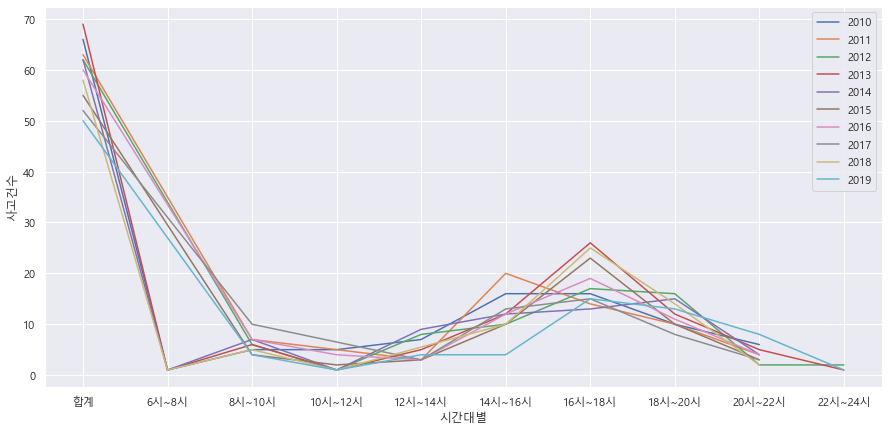

In [ ]:
plt.figure(figsize=(15,7))
f = tca['기준년도'].unique().tolist()
for i in f:
    sns.lineplot('시간대별', '사고건수',data= tca[tca['기준년도'] == i])
plt.legend(f)

* 어린이사고는 하교시간 이후, 특히 16~18시 사이에 많이 발생하는 것을 볼 수 있다.      
* 하교 후 학원으로이동이나 다른 활동을 하다가 사고가 나는 것으로 보인다.      
* 등교시간에도 높게 나올줄 알았지만 그렇지 않다     

#### 요일별 어린이 사고

In [ ]:
a = pd.read_csv('./data/오산시_요일별차대사람어린이사고_2010_2014.csv')
b = pd.read_csv('./data/오산시_요일별차대사람어린이사고_2015_2019.csv')
# day child accident
dca = pd.concat([a,b], axis=0,ignore_index=True) # 년도가 나눠져있어서 합침
dca

,기준년도,요일,사고건수,사망자수,부상자수
0,2010,합계,66,0,66
1,2010,일요일,8,0,8
2,2010,월요일,12,0,12
3,2010,화요일,8,0,8
4,2010,수요일,11,0,11
...,...,...,...,...,...
75,2019,화요일,8,0,8
76,2019,수요일,8,0,8
77,2019,목요일,9,0,9
78,2019,금요일,7,0,7


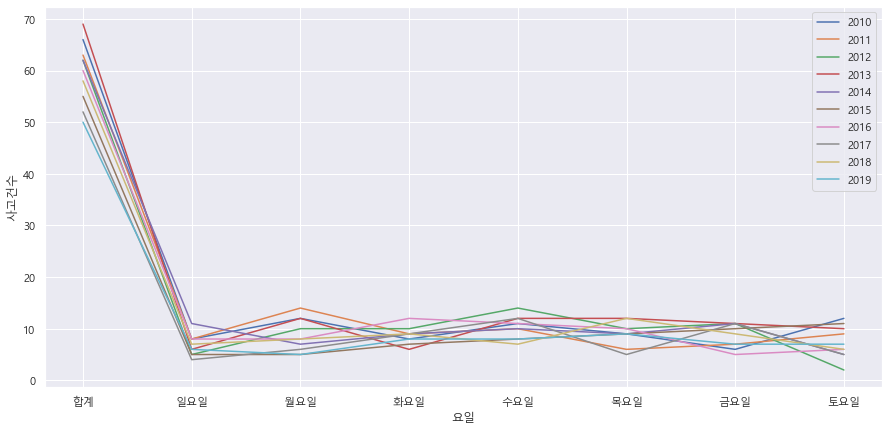

In [ ]:
plt.figure(figsize=(15,7))
f = dca['기준년도'].unique().tolist()
for i in f:
    sns.lineplot('요일', '사고건수',data= dca[dca['기준년도'] == i])
plt.legend(f)

경향을 보기 어려우니 요일별로 합쳐서 봐보자

<AxesSubplot:xlabel='요일'>

<Figure size 1080x504 with 0 Axes>

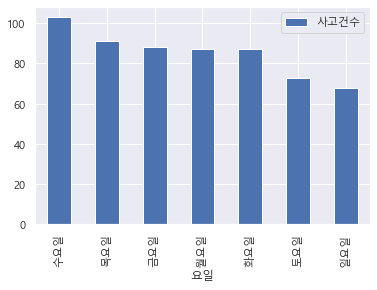

In [ ]:
plt.figure(figsize=(15,7))
f = dca['요일'].unique().tolist()
f=f[1:]
plt.xticks=(f)

dca[['요일','사고건수']].groupby('요일').sum().sort_values(by='사고건수', ascending=False).drop(['합계']).plot.bar()

* 사고는 주말보다 평일에 발생비율이 높은것을 볼 수 있다.   
* 수요일이 사고비율이 가장 높다

### 외부데이터 정리
* 외부데이터와 어린이사고 격자데이터를 병합할 연결고리가 없는 것이 아쉽다  
하지만 다음을 알아냈다.
> 어린이사고는 16~18시경 가장 많이 발생한다.  
> 평일(특히 수요일)이 주말보다 많이 발생한다.

***

## 2. 인구분포 분석
* 목적 : 인구분포에 대한 통찰    
* 데이터종류 : 
> 4.오산시_연령별_거주인구격자(총인구).geojson     
> 5.오산시_연령별_거주인구격자(유소년).geojson

* 분석설명 :
> 빨간색일 수록 해당그리드에 인구가 많다.

#### 총인구분석

In [ ]:
# 총인구 분석
po = gpd.read_file('./data/4.오산시_연령별_거주인구격자(총인구).geojson') # 격자별

po['coordinates'] = po['geometry'].apply(multipolygon_to_coordinates) # coordinates타입으로 반환
del po['geometry']
po = pd.DataFrame(po)
po.fillna(0,inplace=True)
po['pop_val'] = po['val'] / po['val'].max() # 시각화를 위해 정규화
po

,gid,val,coordinates,pop_val
0,다사551085,0.0,"[[126.99421564681425, 37.17418235770403], [126...",0.0
1,다사551086,0.0,"[[126.99420963816323, 37.17508373885349], [126...",0.0
2,다사551087,0.0,"[[126.99420362924478, 37.17598511986466], [126...",0.0
3,다사551088,0.0,"[[126.9941976200589, 37.17688650073755], [126....",0.0
4,다사552085,0.0,"[[126.99534207541716, 37.174187160436155], [12...",0.0
...,...,...,...,...
4505,다사646052,0.0,"[[127.10138369086417, 37.14484471529977], [127...",0.0
4506,다사646053,0.0,"[[127.10137896035867, 37.145746114265314], [12...",0.0
4507,다사647050,0.0,"[[127.10251913455733, 37.14304569816435], [127...",0.0
4508,다사647051,0.0,"[[127.10251441783353, 37.14394709752859], [127...",0.0


In [ ]:
layer = pdk.Layer(
    'PolygonLayer', # 사용할 Layer 타입
    data = po[po['pop_val'] > 0], # 한명이상 거주하는 곳
    get_polygon='coordinates', 
    get_fill_color ='[255*pop_val, 0, 0]',
    pickable=True, # 지도와 interactive 한 동작 on
    auto_highlight=True, # 마우스 오버(hover) 시 박스 출력
    
)

# view_state : 데이터를 기준으로 카메라 위치,각도를 지정함
center = [127.077376, 37.149846]
view_state = pdk.ViewState(
    longitude=center[0],
    latitude=center[1],
    zoom=13,
    )

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state,
            mapbox_key = mapbox_token
            )
#r.show()
r.to_html()

#### 어린이인구분석 + 어린이사고

In [ ]:
# 유소년인구분석

## child population
cpo = gpd.read_file('./data/5.오산시_연령별_거주인구격자(유소년).geojson') # 격자별
cpo['coordinates'] = cpo['geometry'].apply(multipolygon_to_coordinates) # coordinates타입으로 반환
del cpo['geometry']
cpo = pd.DataFrame(cpo)

cpo.fillna(0,inplace=True)
cpo['c_pop_val'] = cpo['val'] / cpo['val'].max() # 정규화
cpo

,gid,val,coordinates,c_pop_val
0,다사551085,0.0,"[[126.99421564681425, 37.17418235770403], [126...",0.0
1,다사551086,0.0,"[[126.99420963816323, 37.17508373885349], [126...",0.0
2,다사551087,0.0,"[[126.99420362924478, 37.17598511986466], [126...",0.0
3,다사551088,0.0,"[[126.9941976200589, 37.17688650073755], [126....",0.0
4,다사552085,0.0,"[[126.99534207541716, 37.174187160436155], [12...",0.0
...,...,...,...,...
4505,다사646052,0.0,"[[127.10138369086417, 37.14484471529977], [127...",0.0
4506,다사646053,0.0,"[[127.10137896035867, 37.145746114265314], [12...",0.0
4507,다사647050,0.0,"[[127.10251913455733, 37.14304569816435], [127...",0.0
4508,다사647051,0.0,"[[127.10251441783353, 37.14394709752859], [127...",0.0


In [ ]:
#어린이 인구
layer = pdk.Layer(
    'PolygonLayer', # 사용할 Layer 타입
    data = cpo[cpo['c_pop_val'] > 0], # 한명이상 거주하는 곳
    get_polygon='coordinates', 
    get_fill_color ='[255*c_pop_val, 0, 0,200]', # 투명도추가
    pickable=True, # 지도와 interactive 한 동작 on
    auto_highlight=True, # 마우스 오버(hover) 시 박스 출력
)

# 어린이사고
layer1 = pdk.Layer(
    'PolygonLayer', # 사용할 Layer 타입
    ca[ca['accident_cnt'] > 0], #사고횟수 1번이상
    get_polygon='coordinates', 
    get_fill_color ='[0, 255*accident_cnt_n, 0,200]', # 투명도추가
    pickable=True, # 지도와 interactive 한 동작 on
    auto_highlight=True # 마우스 오버(hover) 시 박스 출력
)

# view_state : 데이터를 기준으로 카메라 위치,각도를 지정함
center = [127.077376, 37.149846]
view_state = pdk.ViewState(
    longitude=center[0],
    latitude=center[1],
    zoom=13,
)

# Render
r = pdk.Deck(layers=[layer, layer1], initial_view_state=view_state,
            mapbox_key = mapbox_token
            )
r.to_html()

어린이사고 격자데이터도 포함되어있어 출력물은 지웠다

### 분석결과
* 총인구, 유소년인구 모두 비슷한 분포를 띄고있음
* 대원동, 신장동, 중앙동에 인구가 많다
* 인구분포와 어린이사고가 제법 일치한다
* 인구가 많으면 사고수도 많을 것으로 기대

***

## 3. 상세도로망 분석
목적 : 도로의 주요 특징을 시각화해서 통찰을 얻기위해      

데이터종류 : 
> 23.오산시_상세도로망_LV6.geojson   (비공개)

컬럼목록 : 
> link_id  :  해당 링크의 ID.  
max_speed  :  해당 도로의 제한속도.  
road_name  :  해당 도로의 명칭.  
road_no  :  해당 도로의 번호.  
road_rank :   해당 도로의 도로등급코드.  
link_type  :  해당 도로의 링크종별코드.  
road_type  :  해당 도로의 교통시설물 종류.  
facil_name  :  해당 시설 명칭.  
up_lanes :   해당 도로의 상행 차로수.  
dw_lanes  :  해당 도로의 하행 차로수.  
oneway :   해당 도로의 일방통행 구분코드.  
length :   해당 도로의 길이.  
width  :  해당 도로의 도로폭.  
car_lane  :  해당 도로의 자동차전용도로 구분코드.  
num_cross :   해당 도로의 신호등 수.  
barrier  :  해당 도로의 중앙분리대 구분코드.  

분석설명 : 
> 도로의 폭, 최고속도를 시각화해보겠다    
> 도로의 폭이 넓을 수록 선이 굵어지고, 최대속도가 높을수록 빨간색으로 표시하였다.     
> 최대속도(max_speed)가 없거나 어린이보호구역의 최대속도인 30 이하인곳은 파란색으로 표시하였다.

### 비고
해당 데이터는 비공개 데이터이다.  
의미있는 컬럼을 추출하여 어린이사고 격자 데이터와 병합할 것이다.  

이번 대회는 
어린이사고 격자 고유ID별로 다른 데이터를 어떻게 병합 하는가가 매우 중요해보인다. 


In [ ]:
# Detailed Road Network
drn = gpd.read_file('./data/23.오산시_상세도로망_LV6.geojson')
drn['coordinates'] = drn['geometry'].apply(line_string_to_coordinates) # multilinestring을 coordinates형으로 변형
drn = pd.DataFrame(drn)
drn['max_speed']= drn['max_speed'].apply(lambda x : int(x)) # max_speed가 문자열이여서 int형으로 바꿈
drn['max_speed_n'] = drn['max_speed'] / drn['max_speed'].max() # 최대속도 정규화
drn.head()

In [ ]:
# 최대속도가 30 초과인도로와 30 이하인 도로를 나눠서 표시
# 30이하는 파란색, 30 초과는 증가할수록 점점 빨간색을 띄도록하였다.

# 속도 30이상 도로
layer = pdk.Layer(
    'PathLayer', # 사용할 Layer 타입
    data = drn[drn['max_speed'] > 30], # 시각화에 쓰일 데이터프레임
    get_path = 'coordinates',
    get_width = '10*width', # 넓이에따라 굵기 달리주었다
    get_color = '[255*max_speed_n,0,0]', # 최대속도에따라 색 변화
    pickable=True, 
    auto_highlight=True 
)
# 속도 30이하도로
layer1 = pdk.Layer(
    'PathLayer', # 사용할 Layer 타입
    data = drn[drn['max_speed'] <= 30], 
    get_path = 'coordinates',
    get_width = '10*width', # 넓이에따른 굵기
    get_color = '[0,0,255]', # 파란색
    pickable=True, 
    auto_highlight=True 
)
# 어린이사고 수
# 어린이 사고와도 비교를 위해 넣어주었다.
layer2 = pdk.Layer(
    'PolygonLayer', # 사용할 Layer 타입
    ca[ca['accident_cnt'] > 0], # 시각화에 쓰일 데이터프레임
    get_polygon='coordinates', # geometry 정보를 담고있는 컬럼 이름
    get_fill_color ='[0, 255*accident_cnt_n, 0]',
    pickable=True, # 지도와 interactive 한 동작 on
    auto_highlight=True # 마우스 오버(hover) 시 박스 출력
)

# view_state : 데이터를 기준으로 카메라 위치,각도를 지정함
center = [127.077376, 37.149846]
view_state = pdk.ViewState(
    longitude=center[0],
    latitude=center[1],
    zoom=13)

# Render
r = pdk.Deck(layers=[layer, layer1,layer2], initial_view_state=view_state,
            mapbox_key = mapbox_token
            )
r.to_html()

### 분석결과
* 최대속도가 30 이상인 도로에서 사고가많이 발생한다.
* 넓은 도로들이 최대속도또한 넓고 사고 발생율이 높다
* 인구와 어린이사고가 많은 대원동, 중앙동, 신장동에 최대 속도가 30 이상이곳이 많다.

***

## 4. 추정교통량, 혼잡빈도, 혼잡시간
* 목적: 추정교통량, 혼잡빈도, 혼잡시간 에서 의미있는 feature들을 가공

* 데이터종류 : 
> 24.평일_전일,시간대별_오산시_추정교통량_Level6.csv (비공개)    
> 25.평일_전일_오산시_혼잡빈도강도_Level6.csv (비공개)  
> 26.평일_전일_오산시_혼잡시간강도_Level6.csv (비공개)

* 분석설명 : 
> 추정교통량은 도로별 교통량을 시간별로 나눠놓은 것이다    
> 혼잡빈도깅도, 혼잡시간강도 이 둘은 마지막 feature만 제외하고 모두 같은 data이다.



### 비고
위 3 데이터 또한 비공개 데이터 이다.  
해당 데이터 들로 시간대별 혼잡강도를 알 수 있다.   

이 데이터들도 상세도로망에 병합후 어린이사고 격자 데이터에 들어갈 것이다

#### 시간대별_오산시_추정교통량

In [ ]:
# Estimated traffic
et = pd.read_csv('./data/24.평일_전일,시간대별_오산시_추정교통량_Level6.csv')
et['상세도로망_LinkID'] = et['상세도로망_LinkID'].map(lambda x : str(x)) # 문자열로 바꿈
et['ID'] = et['상세도로망_LinkID'].map(lambda x : x[:-2]) # 같은 도로지만 분리해놓은 도로들을 평균내기위해 만듬
et.loc[et['시간적범위']=='전일','시간적범위'] = 24 # 시간적범위가'전일'값을 24로 바꿈
et['시간적범위'] = et['시간적범위'].map(lambda x : int(x)) # 타입이 달라서 groupby하면 이상하게 나옴, 타입 맞춰줌
et.head()

In [ ]:
# 차종이 통합된 전체 교통량을 시간별로 나타내보았다
et[['시간적범위','전체 추정교통량']].groupby('시간적범위').sum().drop([24]).plot.barh(figsize=(10,10))

출근시간인 8시 전후 시간대와, 퇴근시간인 17시 전후 시간대에 교통량이 많다   
우리는 어린이사고에 관련있는 데이터를 모아야한다. 앞의 외부데이터를 활용해서 어린이사고가 16-18시 사이에 많이 일어난다는 것을 알았다.     
때문에 도로별로 16~18시 사이의 교통량을 뽑을 것이다

In [ ]:
# 'ID','시간적범위'로 묶는다
# 같은 도로지만 01, 02로 분리해놓은 도로들을 평균내준다.
x = et.groupby(['ID','시간적범위']).mean()
x

In [ ]:
# 16시, 17시, 18시 교통량을 가져와 평균낸다
et_x = x.xs(16,level='시간적범위')[['전체 추정교통량']] + x.xs(17,level='시간적범위')[['전체 추정교통량']] + x.xs(18,level='시간적범위')[['전체 추정교통량']]
et_x = et_x/3
et_x

* et_x는 위에서분석한 상세도로망에 붙여줄 것이다

#### 오산시_혼잡빈도강도, 오산시_혼잡시간강도,
외부데이터로 어린이 사고는 평일, 16시~18시 사이에 많이 발생하는 것을 알아냈었다.  

혼잡빈도강도와, 혼잡시간강도데이터에서 좋은 기준으로 사용될수 있겠다 싶었는데 아쉽게도 제공되는 데이터는 모두 평일이고, 시간대도 모두 전일이다.  

다행히 추정교통량 데이터는 시간대별로 혼잡도를 제공해준다.

In [ ]:
# Congestion frequency intensity
cfi = pd.read_csv('./data/25.평일_전일_오산시_혼잡빈도강도_Level6.csv')#'상세도로망_LinkID'로 나눠져있고 중복없음
# Congestion time intensity
cti = pd.read_csv('./data/26.평일_전일_오산시_혼잡시간강도_Level6.csv')#'상세도로망_LinkID'로 나눠져있고 중복없음

# cfi, cti데이터는 마지막열만 제외하고 전부 같다. 
# '시간적범위'column은 둘다 '전일' 이고, '평일주말'column은 둘다 '평일' 이다
# cfi의 마지막열인 '혼잡빈도강도' 는 0~100까지의 빈도강도값이 들어있다.
# cti의 마지막열인 '혼잡시간강도' 는 0~100까지의 시간강도값이 들어있다.

cfti = pd.merge(cfi, cti[['상세도로망_LinkID', '혼잡시간강도']], on='상세도로망_LinkID') # merge로 합침
# 빈도와 시간 합쳐서 혼잡강도 만듬
cfti['혼잡강도'] = cfti['혼잡빈도강도'] + cfti['혼잡시간강도'] # min=0, max=200
cfti['상세도로망_LinkID'] = cfti['상세도로망_LinkID'].map(lambda x: str(x))
cfti['ID'] = cfti['상세도로망_LinkID'].map(lambda x : x[:-2]) # 같은 도로지만 분리해놓은 도로들을 평균내기위해 만듬
cfti.head()

In [ ]:
cfti_x = cfti.groupby('ID').mean()
cfti_x = cfti_x[['혼잡강도']]
cfti_x

* cfti_x 또한 위에서분석한 상세도로망에 붙여줄 것이다

#### 이제 상세도로망에 이 데이터들을 붙여주자

In [ ]:
et_x['link_id'] = et_x.index
cfti_x['link_id'] = cfti_x.index

drn_c = pd.merge(drn,et_x, on='link_id', how='left') # ex_x merge
drn_c = pd.merge(drn_c, cfti_x, on='link_id', how='left') # cfti_x merge
# 해당 도로가 없으면 평균으로 채운다.
drn_c['전체 추정교통량'].fillna(drn_c['전체 추정교통량'].mean(axis = 0), inplace=True)
drn_c['혼잡강도'].fillna(drn_c['혼잡강도'].mean(axis=0), inplace =True)

drn_c.head() # 상세도로망에 feature들이 추가됨

In [ ]:
# 정규화
drn_c['전체추정교통량_n'] = drn_c['전체 추정교통량'] / drn_c['전체 추정교통량'].max() # 전체 추정교통량 정규화
drn_c['혼잡강도_n'] = drn_c['혼잡강도'] / drn_c['혼잡강도'].max() # 혼잡강도 정규화

In [ ]:
# 전체추정교통량
layer = pdk.Layer(
    'PathLayer', # 사용할 Layer 타입
    data = drn_c, # 시각화에 쓰일 데이터프레임
    get_path = 'coordinates',
    get_width = '10*width', # 넓이에따라 굵기 달리주었다
    get_color = '[255*전체추정교통량_n,0,0]', # 전체추정교통량에따라 색 변화
    pickable=True, 
    auto_highlight=True 
)

# 어린이사고
layer1 = pdk.Layer(
    'PolygonLayer', # 사용할 Layer 타입
    ca[ca['accident_cnt'] > 0], #사고횟수 1번이상
    get_polygon='coordinates', 
    get_fill_color ='[0, 255*accident_cnt_n, 0,200]', # 투명도추가
    pickable=True, # 지도와 interactive 한 동작 on
    auto_highlight=True # 마우스 오버(hover) 시 박스 출력
)

# view_state : 데이터를 기준으로 카메라 위치,각도를 지정함
center = [127.077376, 37.149846]
view_state = pdk.ViewState(
    longitude=center[0],
    latitude=center[1],
    zoom=13)

# Render
r = pdk.Deck(layers=[layer, layer1], initial_view_state=view_state,
            mapbox_key = mapbox_token
            )
r.to_html()

In [ ]:
# 혼잡강도
layer = pdk.Layer(
    'PathLayer', # 사용할 Layer 타입
    data = drn_c, # 시각화에 쓰일 데이터프레임
    get_path = 'coordinates',
    get_width = '10*width', # 넓이에따라 굵기 달리주었다
    get_color = '[255*혼잡강도_n,0,0]', # 혼잡강도에따라 색 변화
    pickable=True, 
    auto_highlight=True 
)

# 어린이사고
layer1 = pdk.Layer(
    'PolygonLayer', # 사용할 Layer 타입
    ca[ca['accident_cnt'] > 0], #사고횟수 1번이상
    get_polygon='coordinates', 
    get_fill_color ='[0, 255*accident_cnt_n, 0,200]', # 투명도추가
    pickable=True, # 지도와 interactive 한 동작 on
    auto_highlight=True # 마우스 오버(hover) 시 박스 출력
)

# view_state : 데이터를 기준으로 카메라 위치,각도를 지정함
center = [127.077376, 37.149846]
view_state = pdk.ViewState(
    longitude=center[0],
    latitude=center[1],
    zoom=13)

# Render
r = pdk.Deck(layers=[layer, layer1], initial_view_state=view_state,
            mapbox_key = mapbox_token
            )
r.to_html()

### 분석결과
* 전체적으로 도로 교통량과 혼잡도에 따라 사고횟수도 비례하는 것을 볼 수 있다.
* 고속도로(road_rank=101)은 교통량과 혼잡도가 높지만 사고발생비율은 적다. 하지만 고속도로 여부를 특징으로 잡기엔 표본이 부족하다  


***

## 5. 어린이교통사고_격자(100X100)를 지나는 도로 특징들 대입

intersects()함수는 겹쳐있는지 여부를 반환해준다.  
어린이사고 격자고유ID와 도로망의 ID를 연산하여 겹치는도로중 최고속도, 넓이, 교통량, 혼잡강도 의 최대값을 넣을 것이다    
시간이 좀 걸리는 작업이다

In [ ]:
# 각 grid를 지나는 도로들의 최고속도, 넓이, 교통량, 혼잡강도들의 최대값을 ca(어린이사고)에 넣어주겠다.
# 시간이 좀 걸린다.
ca['max_speed'] = np.nan
ca['width'] = np.nan
ca['전체 추정교통량'] = np.nan
ca['혼잡강도'] = np.nan
for i in range(len(ca)):
    arr_max=[]
    arr_w=[]
    arr_c=[]
    arr_c1=[]
    for j in range(len(drn_c)):
        if ca['geometry'][i].intersects(drn_c['geometry'][j]): # ingersects함수는 겹치는것이 있다면 True를 반환한다.
            arr_max.append(float(drn_c.loc[j,'max_speed']))
            arr_w.append(float(drn_c.loc[j,'width']))
            arr_c.append(float(drn_c.loc[j,'전체 추정교통량']))
            arr_c1.append(float(drn_c.loc[j,'혼잡강도']))
    if arr_max:
        ca.loc[i,'max_speed'] = max(arr_max)
        ca.loc[i,'width'] = max(arr_w)
        ca.loc[i,'전체 추정교통량'] = max(arr_c)
        ca.loc[i,'혼잡강도'] = max(arr_c1)
    if i% 100 == 0:
        print(i)
#pd.DataFrame(ca).to_csv("./data/accident_0.csv", index = False) 

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500


In [ ]:
ca.head() # ca에 새로운 feature들이 생긴것을 볼 수 있다. 도로에 겹치는 grid가있으면 값이 생성된다.

## 6. 어린이교통사고_격자(100X100)에 cctv, 방지턱, 무인카메라, 어린이보호구역 부여
목적 : gird에 다른 요소들을 부여하겠다.  

데이터종류 : 
> 20.오산시_CCTV설치현황.csv'   
> 18.오산시_과속방지턱표준데이터.csv    
> 15.오산시_무인교통단속카메라.csv     
> 9.오산시_어린이보호구역.csv   

분석설명 : 
> 어린이보호용 cctv를 뽑아서 격자에 부여  
> 과속방지턱 부여
> 무인교통단속 카메라 부여   
> 어린이보호구역 부여 

시간이 꽤 걸리는 작업이다

In [ ]:
cctv = pd.read_csv('./data/20.오산시_CCTV설치현황.csv')
cctv = cctv[cctv['CCTV 유형코드'] == 'C']
cctv['설치위치_경도'] = cctv['설치위치_경도'].astype(float)
cctv['설치위치_위도'] = cctv['설치위치_위도'].astype(float)
cctv['geometry'] = cctv.apply(lambda row : Point([row['설치위치_경도'], row['설치위치_위도']]), axis=1)
cctv = gpd.GeoDataFrame(cctv, geometry='geometry')
cctv.reset_index(inplace=True)
cctv

,index,CCTV 유형코드,설치위치_도로명주소,설치위치_위도,설치위치_경도,geometry
0,2,C,성호대로93번길 26,37.151167,127.071677,POINT (127.07168 37.15117)
1,7,C,성산새싹길 13,37.150370,127.065719,POINT (127.06572 37.15037)
2,15,C,현충로72번길 24,37.160448,127.073239,POINT (127.07324 37.16045)
3,17,C,성호새싹길 8,37.149657,127.070278,POINT (127.07028 37.14966)
4,22,C,대원로29번길 16,37.147547,127.071512,POINT (127.07151 37.14755)
...,...,...,...,...,...,...
120,405,C,서동로 123-9,37.151313,127.039226,POINT (127.03923 37.15131)
121,436,C,부산중앙로 37,37.152077,127.091524,POINT (127.09152 37.15208)
122,450,C,NaN,37.169191,127.026973,POINT (127.02697 37.16919)
123,451,C,NaN,37.170237,127.028031,POINT (127.02803 37.17024)


In [ ]:
# cctv 병합
ca['cctv'] = 0
for i in range(len(ca)):
    cnt=0
    for j in range(len(cctv)):
        if ca['geometry'][i].intersects(cctv['geometry'][j]):
            cnt+=1
    if cnt:
        ca.loc[i,'cctv'] = cnt
    print(i)
    if i % 100 ==0:
        print(ca.loc[i,:])

0
gid                                                        다사551085
accident_cnt                                                      0
geometry          (POLYGON ((126.9942156468143 37.17418235770403...
coordinates       [[126.99421564681425, 37.17418235770403], [126...
accident_cnt_n                                                    0
coord_cent                 [126.99477586013964, 37.174635450576154]
geo_cent                POINT (126.9947758601396 37.17463545057615)
max_speed                                                       NaN
width                                                           NaN
전체 추정교통량                                                        NaN
혼잡강도                                                            NaN
cctv                                                              0
Name: 0, dtype: object
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


In [ ]:
#18.오산시_과속방지턱표준데이터.csv
#Speed bump
sd = pd.read_csv('./data/18.오산시_과속방지턱표준데이터.csv')
sd['설치위치_경도'] = sd['설치위치_경도'].astype(float)
sd['설치위치_위도'] = sd['설치위치_위도'].astype(float)
sd['geometry'] = sd.apply(lambda row : Point([row['설치위치_경도'], row['설치위치_위도']]), axis=1)
sd = gpd.GeoDataFrame(sd, geometry='geometry')
sd.reset_index(inplace=True)
sd.head()

,index,도로명,설치장소명,과속방지턱높이,과속방지턱폭,과속방지턱연장,보차분리여부,연속형여부,설치위치_경도,설치위치_위도,geometry
0,0,오산로,소망빌 앞,10,3.6,5.4,N,Y,127.068954,37.130852,POINT (127.06895 37.13085)
1,1,동부대로,태영철강재공장 앞,10,3.6,5.0,N,Y,127.076305,37.137946,POINT (127.07630 37.13795)
2,2,밀머리로,메디마트 앞,0,3.6,5.4,Y,Y,127.075093,37.141466,POINT (127.07509 37.14147)
3,3,오산로,다인하우스 앞,10,3.6,10.0,Y,Y,127.071169,37.143833,POINT (127.07117 37.14383)
4,4,운천로,운천고등학교 앞,10,3.6,6.0,Y,Y,127.080466,37.155872,POINT (127.08047 37.15587)
5,5,성호대로,오산우체국 앞,10,3.6,5.0,Y,Y,127.070781,37.149169,POINT (127.07078 37.14917)
6,6,경기대로,오산동 어린이공원 앞,10,3.6,6.0,N,Y,127.072608,37.151294,POINT (127.07261 37.15129)
7,7,청학로,오산중학교 앞,10,3.6,6.5,Y,Y,127.061185,37.155124,POINT (127.06118 37.15512)
8,8,청학로,세산다세대 부근,10,3.6,4.3,Y,N,127.062582,37.152656,POINT (127.06258 37.15266)
9,9,청학로,정석빌딩 앞,10,3.6,4.4,Y,N,127.062101,37.150484,POINT (127.06210 37.15048)


In [ ]:
# 방지턱 병합
ca['방지턱'] = 0
for i in range(len(ca)):
    cnt=0
    for j in range(len(sd)):
        if ca['geometry'][i].intersects(sd['geometry'][j]):
            cnt+=1
    if cnt:
        ca.loc[i,'방지턱'] = cnt
    print(i)
    if i % 100 ==0:
        print(ca.loc[i,:])

0
gid                                                        다사551085
accident_cnt                                                      0
geometry          (POLYGON ((126.9942156468143 37.17418235770403...
coordinates       [[126.99421564681425, 37.17418235770403], [126...
accident_cnt_n                                                    0
coord_cent                 [126.99477586013964, 37.174635450576154]
geo_cent                POINT (126.9947758601396 37.17463545057615)
max_speed                                                       NaN
width                                                           NaN
전체 추정교통량                                                        NaN
혼잡강도                                                            NaN
cctv                                                              0
방지턱                                                               0
Name: 0, dtype: object
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
3

In [ ]:
# 15.오산시_무인교통단속카메라.csv
camera = pd.read_csv('./data/15.오산시_무인교통단속카메라.csv')
camera['설치위치_경도'] = camera['설치위치_경도'].astype(float)
camera['설치위치_위도'] = camera['설치위치_위도'].astype(float)
camera['geometry'] = camera.apply(lambda row : Point([row['설치위치_경도'], row['설치위치_위도']]), axis=1)
camera = gpd.GeoDataFrame(camera, geometry='geometry')
camera.reset_index(inplace=True)
camera.head()

,index,도로노선명,도로노선방향,설치장소명,단속구분,설치위치_경도,설치위치_위도,geometry
0,0,궐리사로,양방향,궐동-법원앞(법원사거리),불법주정차,127.059357,37.159313,POINT (127.05936 37.15931)
1,1,역광장로,양방향,원동-오산역광장,불법주정차,127.067796,37.145409,POINT (127.06780 37.14541)
2,2,궐리사로,양방향,궐동-제일하이빌,불법주정차,127.062386,37.159198,POINT (127.06239 37.15920)
3,3,궐리사로,양방향,궐리사 주차장 앞,불법주정차,127.061920,37.158559,POINT (127.06192 37.15856)
4,4,운암로,양방향,부산동-운천초교 입구,불법주정차,127.077991,37.156216,POINT (127.07799 37.15622)


In [ ]:
# 단속카메라 병합
ca['무인카메라'] = 0
for i in range(len(ca)):
    cnt=0
    for j in range(len(camera)):
        if ca['geometry'][i].intersects(camera['geometry'][j]):
            cnt+=1
    if cnt:
        ca.loc[i,'무인카메라'] = cnt
    print(i)
    if i % 100 ==0:
        print(ca.loc[i,:])
#pd.DataFrame(ca).to_csv("./data/accident_1.csv", index = False) 

0
gid                                                        다사551085
accident_cnt                                                      0
geometry          (POLYGON ((126.9942156468143 37.17418235770403...
coordinates       [[126.99421564681425, 37.17418235770403], [126...
accident_cnt_n                                                    0
coord_cent                 [126.99477586013964, 37.174635450576154]
geo_cent                POINT (126.9947758601396 37.17463545057615)
max_speed                                                       NaN
width                                                           NaN
전체 추정교통량                                                        NaN
혼잡강도                                                            NaN
cctv                                                              0
방지턱                                                               0
무인카메라                                                             0
Name: 0, dtype: object
1
2
3
4
5
6
7
8
9
10
11

In [ ]:
#9.오산시_어린이보호구역.csv
# Protected area
pa = pd.read_csv('./data/9.오산시_어린이보호구역.csv')
pa['설치위치_경도'] = pa['보호구역_경도'].astype(float)
pa['설치위치_위도'] = pa['보호구역_위도'].astype(float)
pa['geometry'] = pa.apply(lambda row : Point([row['설치위치_경도'], row['설치위치_위도']]), axis=1)
pa = gpd.GeoDataFrame(camera, geometry='geometry')
pa.reset_index(inplace=True)
pa.head()

,level_0,index,도로노선명,도로노선방향,설치장소명,단속구분,설치위치_경도,설치위치_위도,geometry
0,0,0,궐리사로,양방향,궐동-법원앞(법원사거리),불법주정차,127.059357,37.159313,POINT (127.05936 37.15931)
1,1,1,역광장로,양방향,원동-오산역광장,불법주정차,127.067796,37.145409,POINT (127.06780 37.14541)
2,2,2,궐리사로,양방향,궐동-제일하이빌,불법주정차,127.062386,37.159198,POINT (127.06239 37.15920)
3,3,3,궐리사로,양방향,궐리사 주차장 앞,불법주정차,127.061920,37.158559,POINT (127.06192 37.15856)
4,4,4,운암로,양방향,부산동-운천초교 입구,불법주정차,127.077991,37.156216,POINT (127.07799 37.15622)


In [ ]:
# 어린이 보호구역 병합
ca['보호구역'] = 0
for i in range(len(ca)):
    cnt=0
    for j in range(len(pa)):
        if ca['geometry'][i].intersects(pa['geometry'][j]):
            cnt+=1
    if cnt:
        ca.loc[i,'보호구역'] = cnt
    print(i)
    if i % 100 ==0:
        print(ca.loc[i,:])
#pd.DataFrame(ca).to_csv("./data/accident_2.csv", index = False) 

0
gid                                                        다사551085
accident_cnt                                                      0
geometry          (POLYGON ((126.9942156468143 37.17418235770403...
coordinates       [[126.99421564681425, 37.17418235770403], [126...
accident_cnt_n                                                    0
coord_cent                 [126.99477586013964, 37.174635450576154]
geo_cent                POINT (126.9947758601396 37.17463545057615)
max_speed                                                       NaN
width                                                           NaN
전체 추정교통량                                                        NaN
혼잡강도                                                            NaN
cctv                                                              0
방지턱                                                               0
무인카메라                                                             0
보호구역                                          

***
***

In [ ]:
ca.head()

,gid,accident_cnt,geometry,coordinates,accident_cnt_n,coord_cent,geo_cent,max_speed,width,전체 추정교통량,혼잡강도,cctv,방지턱,무인카메라,보호구역
0,다사551085,0,"MULTIPOLYGON (((126.99422 37.17418, 126.99421 ...","[[126.99421564681425, 37.17418235770403], [126...",0.0,"[126.99477586013964, 37.174635450576154]",POINT (126.9947758601396 37.17463545057615),NaN,NaN,NaN,NaN,0,0,0,0
1,다사551086,0,"MULTIPOLYGON (((126.99421 37.17508, 126.99420 ...","[[126.99420963816323, 37.17508373885349], [126...",0.0,"[126.9947698580453, 37.17553683173449]",POINT (126.9947698580453 37.17553683173449),NaN,NaN,NaN,NaN,0,0,0,0
2,다사551087,0,"MULTIPOLYGON (((126.99420 37.17599, 126.99420 ...","[[126.99420362924478, 37.17598511986466], [126...",0.0,"[126.99476385568379, 37.17643821275453]",POINT (126.9947638556838 37.17643821275453),NaN,NaN,NaN,NaN,0,0,0,0
3,다사551088,0,"MULTIPOLYGON (((126.99420 37.17689, 126.99419 ...","[[126.9941976200589, 37.17688650073755], [126....",0.0,"[126.99475785305518, 37.17733959363628]",POINT (126.9947578530552 37.17733959363628),NaN,NaN,NaN,NaN,0,0,0,0
4,다사552085,0,"MULTIPOLYGON (((126.99534 37.17419, 126.99534 ...","[[126.99534207541716, 37.174187160436155], [12...",0.0,"[126.9959022955662, 37.174640248032546]",POINT (126.9959022955662 37.17464024803255),NaN,NaN,NaN,NaN,0,0,0,0


## 7.상관관계분석
겹치는 도로가 없다는 것도 특성으로 사용하기위해 분석에 사용하는 알고리즘은 lightgbm이다.  

In [ ]:
ca['max_speed_n'] = ca['max_speed']/ ca['max_speed'].max()
ca['width_n'] = ca['width']/ ca['width'].max()
ca['전체추정교통량_n'] = ca['전체 추정교통량']/ ca['전체 추정교통량'].max()
ca['혼잡강도_n'] = ca['혼잡강도']/ ca['혼잡강도'].max()
ca['cctv_n'] = ca['cctv']/ ca['cctv'].max()
ca['방지턱_n'] = ca['방지턱']/ ca['방지턱'].max()
ca['무인카메라_n'] = ca['무인카메라']/ ca['무인카메라'].max()
ca['보호구역_n'] = ca['보호구역']/ ca['보호구역'].max()

In [ ]:
ca.head()

,gid,accident_cnt,geometry,coordinates,accident_cnt_n,coord_cent,geo_cent,max_speed,width,전체 추정교통량,...,무인카메라,보호구역,max_speed_n,width_n,전체추정교통량_n,혼잡강도_n,cctv_n,방지턱_n,무인카메라_n,보호구역_n
0,다사551085,0,"MULTIPOLYGON (((126.99422 37.17418, 126.99421 ...","[[126.99421564681425, 37.17418235770403], [126...",0.0,"[126.99477586013964, 37.174635450576154]",POINT (126.9947758601396 37.17463545057615),NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1,다사551086,0,"MULTIPOLYGON (((126.99421 37.17508, 126.99420 ...","[[126.99420963816323, 37.17508373885349], [126...",0.0,"[126.9947698580453, 37.17553683173449]",POINT (126.9947698580453 37.17553683173449),NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2,다사551087,0,"MULTIPOLYGON (((126.99420 37.17599, 126.99420 ...","[[126.99420362924478, 37.17598511986466], [126...",0.0,"[126.99476385568379, 37.17643821275453]",POINT (126.9947638556838 37.17643821275453),NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
3,다사551088,0,"MULTIPOLYGON (((126.99420 37.17689, 126.99419 ...","[[126.9941976200589, 37.17688650073755], [126....",0.0,"[126.99475785305518, 37.17733959363628]",POINT (126.9947578530552 37.17733959363628),NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
4,다사552085,0,"MULTIPOLYGON (((126.99534 37.17419, 126.99534 ...","[[126.99534207541716, 37.174187160436155], [12...",0.0,"[126.9959022955662, 37.174640248032546]",POINT (126.9959022955662 37.17464024803255),NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0


In [ ]:
ca_LR = ca
X = ca_LR[["max_speed_n","width_n","전체추정교통량_n","혼잡강도_n",'cctv_n','방지턱_n','무인카메라_n','보호구역_n']]
y = ca_LR["accident_cnt"]

In [ ]:
import lightgbm as lgb
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'importance_type':'gain'
}
gbm = lgb.LGBMRegressor(**hyper_params)
gbm.fit(X, y)

LGBMRegressor(importance_type='gain', objective='regression', task='train')

In [ ]:
importance = gbm.feature_importances_
importance

array([1.71607409e+02, 2.80610195e+02, 1.17667344e+03, 1.70620618e+03,
       4.01537212e+01, 8.21238011e-01, 4.20088718e+01, 0.00000000e+00])

### 혼잡강도_n, 전체추정교통량_n, width_n, max_speed_n, 무인카메라_n, cctv_n, 방지턱_n,보호구역_n 순으로 중요하다

In [ ]:
# importance 정규화
importance_n = []
m = importance.max()
for i in importance:
    importance_n.append(i/m)
importance_n

[0.10057835379512892,
 0.1644644114288745,
 0.6896431692362589,
 1.0,
 0.02353392085069864,
 0.00048132401626249676,
 0.024621216555608227,
 0.0]

In [ ]:
features = ["max_speed","width","전체 추정교통량","혼잡강도",'cctv','방지턱','무인카메라','보호구역']

In [ ]:
result1 = ca.copy()

#### importance_n과 분석에 사용한 feature들을 곱한뒤 열 별로 더해준다. r 에 저장

In [ ]:
# importance_n과 분석에 사용한 feature들을 곱한뒤 열 별로 더해준다. r 에 저장
result1['r'] = (result1['max_speed'] * importance_n[0]) + (result1['width'] * importance_n[1]) +(result1['전체 추정교통량'] * importance_n[2]) + (result1['혼잡강도'] * importance_n[3]) +(result1['cctv'] * importance_n[4]) + (result1['방지턱'] * importance_n[5]) + (result1['무인카메라'] * importance_n[6]) + (result1['보호구역'] * importance_n[7])

***
***

# 결과도출

### 1번 과제

In [ ]:
answer1 = result1[['coord_cent','r']].sort_values(by='r', ascending=False).reset_index().loc[:19, 'coord_cent'] # 상위 20 개만 가져온다
#pd.DataFrame(answer1).to_csv("./data/answer1.csv", index = False) 
answer1

0     [127.08393303132551, 37.144334035917396]
1         [127.08724734860981, 37.15606400173]
2     [127.08612608780541, 37.155158678592564]
3     [127.08612117440191, 37.156060074279075]
4      [127.08392809382237, 37.14523543300359]
5      [127.08392315609949, 37.14613682995179]
6     [127.08393796860891, 37.143432638693234]
7     [127.08390834161244, 37.148841019968536]
8      [127.08501963208056, 37.15154915695452]
9      [127.08501470618546, 37.15245055306508]
10     [127.08500978007113, 37.15335194903765]
11     [127.08389846418885, 37.15064381262312]
12     [127.08390340301054, 37.14974241636482]
13    [127.08391327999453, 37.147939623434276]
14     [127.08391821815688, 37.14703822676202]
15     [127.08613100099026, 37.15425728276807]
16     [127.08613591395645, 37.15335588680557]
17     [127.08502455775647, 37.15064776070598]
18     [127.08962633296478, 37.13263548191835]
19    [127.08850050571122, 37.132631579166315]
Name: coord_cent, dtype: object

### 2번 과제
어린이보호구역만 해당하는 그리드를 학습시키기엔 너무 적어서 그리드 전부로 학습시킨 모델을 사용할 것이다    
어린이보호구역이 포함되고 r 값이 높은 순으로 저장하겠다

In [ ]:
result2 = result1[result1['보호구역'] > 0]

In [ ]:
answer2 = result2[['coord_cent','r']].sort_values(by='r', ascending=False).reset_index().loc[:19, 'coord_cent']
#pd.DataFrame(answer2).to_csv("./data/answer2.csv", index = False) 
answer2

0      [127.08507380246121, 37.14163379063161]
1     [127.07274401519757, 37.131674420296775]
2       [127.073788925321, 37.146100821617885]
3       [127.0737990410567, 37.14429802992267]
4      [127.07380409858696, 37.14339663386807]
5      [127.07374339336694, 37.15421337741478]
6     [127.07376363204239, 37.150607798440745]
7     [127.07381421297224, 37.141593841344836]
8     [127.06363399752225, 37.149669523785164]
9      [127.07710174728732, 37.15783105833984]
10      [127.0738344390424, 37.13798825464235]
11     [127.07039555686565, 37.14879281161637]
12      [127.07152162102741, 37.1487968878173]
13     [127.07489981486812, 37.14880905223301]
14    [127.07821793094173, 37.159637860258606]
15     [127.06126725774949, 37.16949183840903]
16    [127.06012521363836, 37.172191833738715]
17    [127.06689910933768, 37.169512555818066]
18     [127.07144022411241, 37.16321919065916]
19      [127.06235203840184, 37.1767071251847]
Name: coord_cent, dtype: object

### 최종결과물

In [ ]:
answer = pd.concat([answer1, answer2], axis = 1)
#pd.DataFrame(answer).to_csv("./data/answer.csv", index = False)
answer

,coord_cent,coord_cent
0,"[127.08393303132551, 37.144334035917396]","[127.08507380246121, 37.14163379063161]"
1,"[127.08724734860981, 37.15606400173]","[127.07274401519757, 37.131674420296775]"
2,"[127.08612608780541, 37.155158678592564]","[127.073788925321, 37.146100821617885]"
3,"[127.08612117440191, 37.156060074279075]","[127.0737990410567, 37.14429802992267]"
4,"[127.08392809382237, 37.14523543300359]","[127.07380409858696, 37.14339663386807]"
5,"[127.08392315609949, 37.14613682995179]","[127.07374339336694, 37.15421337741478]"
6,"[127.08393796860891, 37.143432638693234]","[127.07376363204239, 37.150607798440745]"
7,"[127.08390834161244, 37.148841019968536]","[127.07381421297224, 37.141593841344836]"
8,"[127.08501963208056, 37.15154915695452]","[127.06363399752225, 37.149669523785164]"
9,"[127.08501470618546, 37.15245055306508]","[127.07710174728732, 37.15783105833984]"
